# Decision Trees

In general, algorithms for training decision trees choose the best variable to split the dataset, in a manner that in each branch we will have a smaller mixture of classes. Then the algorithm repeats in the same way for each branch, until it reaches a pure leaf (a node with all the records of the same class) or there are no more variables to split the data.

The choice of the best variable is done according to a criterion: entropy and giny for implementing the information gain and giny impurity functions, respectively.

Among the several parameters, the max_depth determines the maximum size of the tree to reach, implementing a pre-pruning strategy. Other parameters with similar effects are the min_samples_leaf, min_samples_split and min_impurity_decrease thresholds, that avoid continuing growing the tree.

The min_impurity_decrease parameter implements the post-pruning strategy, since it only splits some node, if it brings more accuracy to the model.

This pair of notebooks is organized in the following manner:
* [HF] Applying the conclusions drawn on TrainingModels to:
    * Original Dataset (No Pruning vs. Pruning)
    * Scaled (Standardized)
    * Scaled & Outliers (Winsorization)
    * Balanced
    * Balanced & Standardized Stan
    
* [ORAL] Applying the conclusions drawn on TrainingModels to:
    * Original Dataset

## Original Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
import ds_functions as ds

data: pd.DataFrame = pd.read_csv('../datasets/qsar_oral_toxicity.csv', sep=';', header=None)
y: np.ndarray = data.iloc[:,-1:].values
y: np.ndarray = np.array([x[0] for x in y])
X: np.ndarray = data.iloc[:,:-1]
labels = pd.unique(y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None

n = 1

n_holdouts = 1

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
            
            total_acc = 0
            
            # Computing the average accuracy for this combination of hyper-parameters
            for h in range(n_holdouts):
                trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp)
                tree.fit(trnX, trnY)
                prdY = tree.predict(tstX)
                total_acc += metrics.accuracy_score(tstY, prdY)
                
            total_acc /= n_holdouts
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

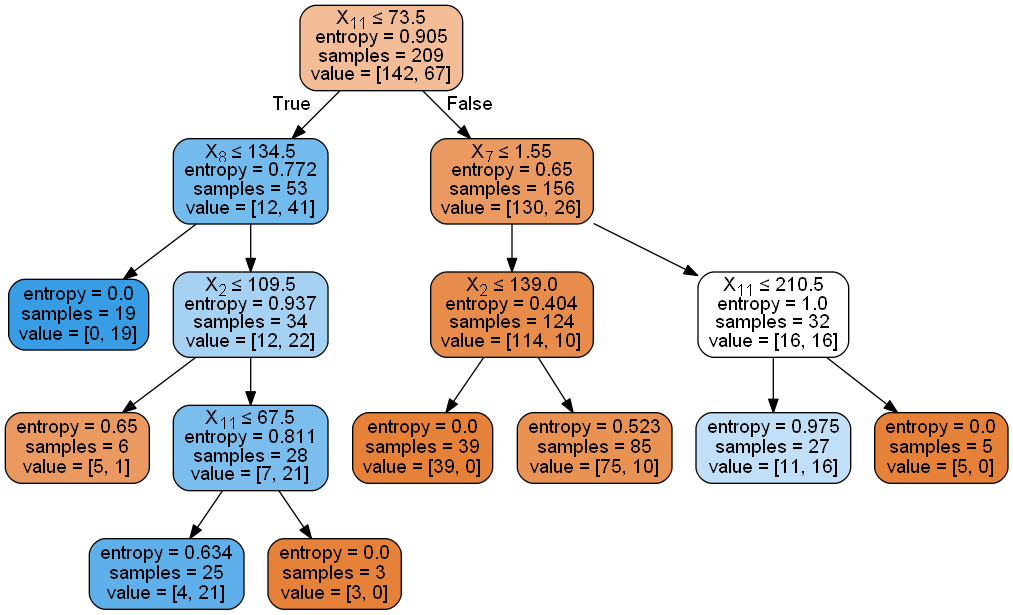

In [18]:
from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(best_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

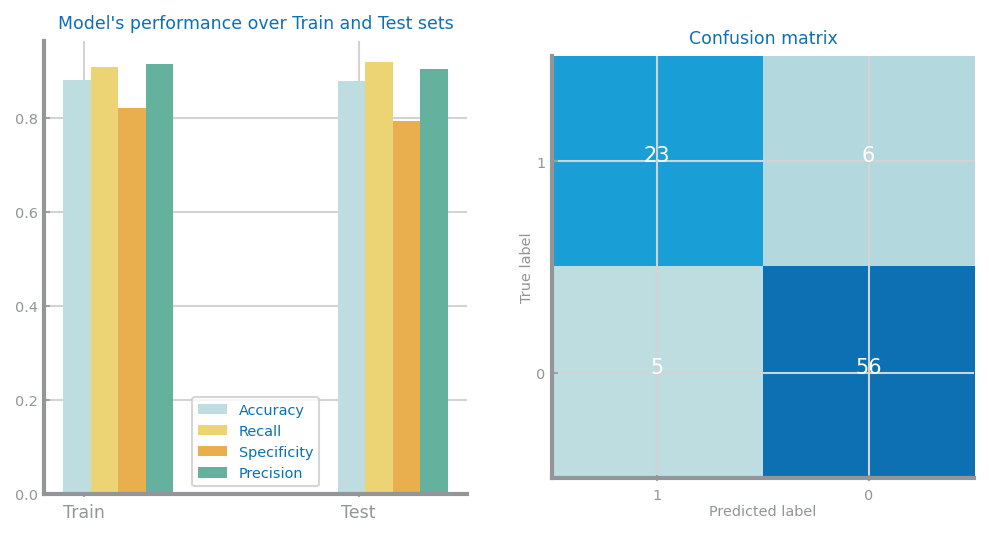

In [19]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

## Pruning
The performance of a tree can be further increased by pruning. It involves removing the branches that make use of features having low importance. This way, we reduce the complexity of tree, and thus increasing its predictive power by reducing overfitting.

Pruning can start at either root or the leaves. The simplest method of pruning starts at leaves and removes each node with most popular class in that leaf, this change is kept if it doesn't deteriorate accuracy. Its also called reduced error pruning. More sophisticated pruning methods can be used such as cost complexity pruning where a learning parameter (alpha) is used to weigh whether nodes can be removed based on the size of the sub-tree. This is also known as weakest link pruning.

**This model does not seem be overfit, so pruning does not make as much sense. Regardless, let us check if it improves overall model performance**

### Cost-complexity Pruning (Weakest Link Pruning)

<Figure size 600x450 with 0 Axes>

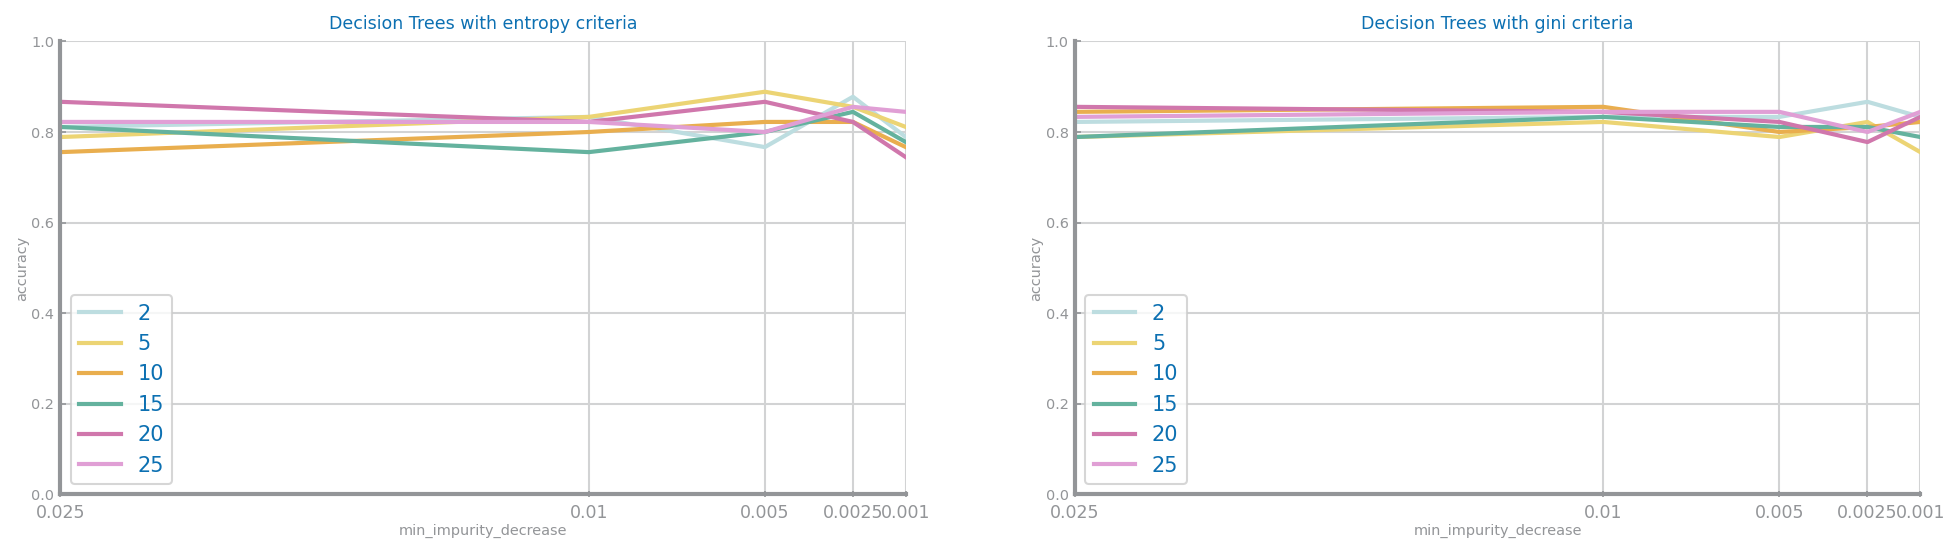

Best results achieved with entropy criteria, depth=5 and min_impurity_decrease=0.01 ==> accuracy=0.89


In [22]:
data: pd.DataFrame = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)

min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
ccp_alphas = [0, 0.005, 0.010, 0.015, 0.020, 0.025, 0.030]
best = ('',  0, 0.0)
last_best = 0
best_tree = None

n = 1

n_holdouts = 1000

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    for d in max_depths:
        yvalues = []
        for imp in min_impurity_decrease:
                 
            total_acc = 0

            # Computing the average accuracy for this combination of hyper-parameters
            for h in range(n_holdouts):
                
                for ccp_alpha in ccp_alphas:

                    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

                    tree = DecisionTreeClassifier(min_samples_leaf=n, max_depth=d, criterion=f, min_impurity_decrease=imp, ccp_alpha=ccp_alpha)
                    tree.fit(trnX, trnY)
                    prdY = tree.predict(tstX)
                    total_acc += metrics.accuracy_score(tstY, prdY)

            total_acc /= n_holdouts * len(ccp_alphas)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

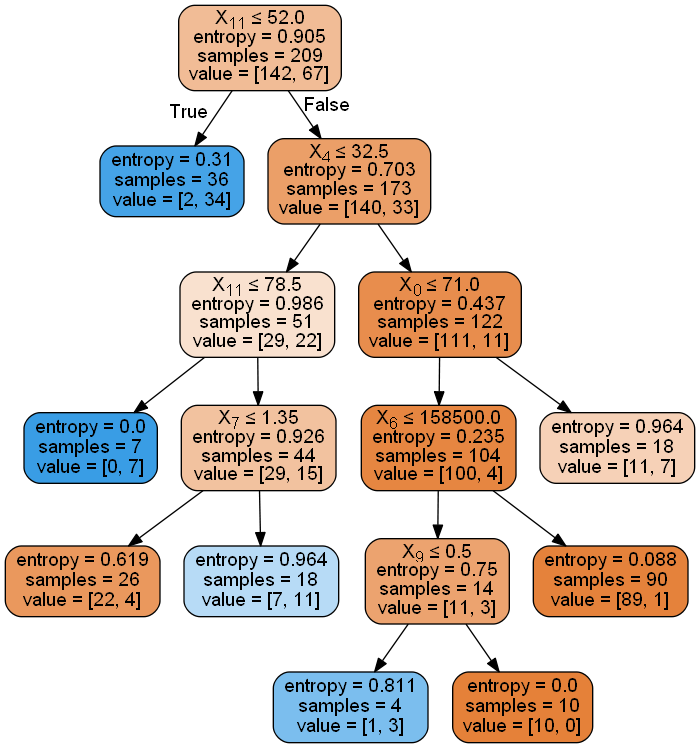

In [23]:
dot_data = StringIO()
export_graphviz(best_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

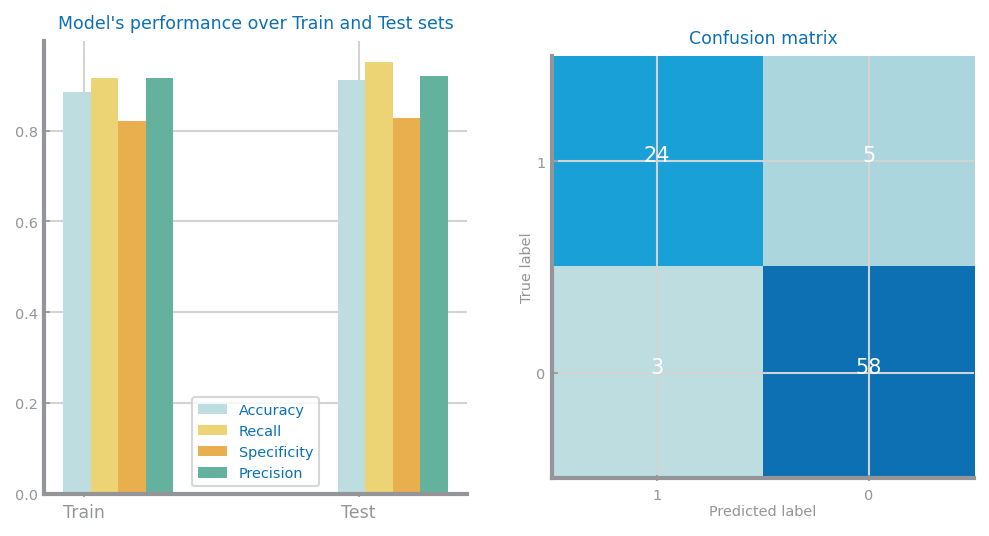

In [24]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)